November: Animations of speeds (using U and V) profiles at different depths using pcolormesh and contour lines.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib
importlib.reload(general_functions)

<module 'general_functions' from '/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/general_functions.py'>

In [3]:
def get_vars(dirname, fname, dep_ind):
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
    print('files')
    
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW:
        vozocrtx0 = dsU.variables['vozocrtx'][:,dep_ind,y,x]
        print('U')
        vomecrty0 = dsV.variables['vomecrty'][:,dep_ind,y,x]
        print('V')
        vovecrtz0 = dsW.variables['vovecrtz'][:,dep_ind,y,x]
        print('W')
        depthu = dsU.variables['depthu'][dep_ind]
        sozotaux = dsU.variables['sozotaux'][:,0,0] 

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,dep_ind,y,x]
        vmask0 = dsM.variables['vmask'][0,dep_ind,y,x]
        tmask0 = dsM.variables['tmask'][0,dep_ind,y,x]

    umask = np.tile(umask0, (480, 1, 1))
    vmask = np.tile(vmask0, (480, 1, 1))
    tmask = np.tile(tmask0, (480, 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    
    return vozocrtx, vomecrty, vovecrtz, depthu, sozotaux

In [4]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
fname = "1_MCKNZ_1h_20170101_20170120_*"

dep_inds = [9, 12, 18]

vozocrtxA, vomecrtyA, vovecrtzA, depthuA, sozotaux = get_vars(dirname, fname, dep_inds[0]); print('A')
vozocrtxB, vomecrtyB, vovecrtzB, depthuB, sozotaux = get_vars(dirname, fname, dep_inds[1]); print('B')
vozocrtxC, vomecrtyC, vovecrtzC, depthuC, sozotaux = get_vars(dirname, fname, dep_inds[2]); print('C')


files
U
V
W
A
files
U
V
W
B
files
U
V
W
C


In [5]:
avgU_full = nc.Dataset('./U_incoming.nc')['U'][:]

In [6]:
def get_speeds(U_vel, V_vel, arrow):
    '''This function unstaggers the velocity components
    and calculates the speeds at arrow intervals.
    
    #from /ocean/imachuca/Canyons/mackenzie_canyon/tools/functions_velocity.py
    '''
    ugrid = U_vel[:]
    vgrid = V_vel[:]
    u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
    v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
    u_nstg = u_nstg0[::arrow,::arrow]
    v_nstg = v_nstg0[::arrow,::arrow]
    x_slice = np.arange(1, ugrid.shape[1])[::arrow]
    y_slice = np.arange(1, ugrid.shape[0])[::arrow]
    speeds = np.sqrt(u_nstg**2 + v_nstg**2)
    return x_slice, y_slice, u_nstg, v_nstg, speeds

In [7]:
vozocrtxs = [vozocrtxA, vozocrtxB, vozocrtxC]
vomecrtys = [vomecrtyA, vomecrtyB, vomecrtyC]
depthus = [depthuA, depthuB, depthuC]


def init():
    for vozocrtx, vomecrty, ax in zip (vozocrtxs, vomecrtys, [ax1, ax2, ax3]):
        U_vel = vozocrtx[0,...]
        V_vel = vomecrty[0,...]
        x_slice, y_slice, u_nstg, v_nstg, speeds = get_speeds(U_vel, V_vel, 1)
        ax, xs, ys = general_functions.set_xy(ax, speeds, 'childkm')
        cs = ax.contour(xs, ys, speeds, levels = levels, colors='k', alpha=0.5)
    return cs,

# ------------------------------------------------------------------------------------

def animate(time_ind):
    ax1.cla(); ax2.cla(); ax3.cla()
    
    cmap = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)
    cmap.set_bad('wheat')
    
    for ax, vozocrtx, vomecrty, depm in zip ([ax1, ax2, ax3], vozocrtxs, vomecrtys, depthus):
        
        ax = general_functions.set_plots_after_clear(ax, depm, 'top')
        U_vel = vozocrtx[time_ind,...]
        V_vel = vomecrty[time_ind,...]
        x_slice, y_slice, u_nstg, v_nstg, speeds = get_speeds(U_vel, V_vel, 1)
        ax, xs, ys = general_functions.set_xy(ax, speeds, 'childkm')
        
        p = ax.pcolormesh(xs, ys, speeds, vmin = levels[0], vmax = levels[-1], cmap = cmap)
        cs = ax.contour(xs, ys, speeds, levels = levels, colors='k', alpha=0.5)
        ax.clabel(cs, inline=1, fontsize=10)
        ax.set_aspect(aspect='equal')
        
        if time_ind == 0:
            cbar = plt.colorbar(p, ax=ax, pad=0.1, orientation='horizontal', extend='both')
            cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
            cbar.set_label('[m s$^{-1}$]', fontsize=18, rotation=0, labelpad=2.5)
        else:
            pass
        
    axa.plot(sozotaux[:time_ind], c='#384e72', linewidth=2.5)
    axb.plot(avgU_full[:time_ind], c='#384e72', linewidth=2.5)
    axa.set_ylim([-0.15, 0])
    axb.set_ylim([-0.1, 0])
    
    for ax in (axa, axb):
        ax.set_xlim([0, 10*24])
        ml = MultipleLocator(24)
        ax.xaxis.set_minor_locator(ml)
        ax.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    return cs,

In [8]:
colour_list = [
"#c8274c",
"#f25546",
"#F06543",
"#e96e33",
"#f0b038",
"#FFE74C",
"#69b944",
"#72b286",
"#69b0bc",
"#619ee4",
"#4b5bbb"][::-1]

[ 0.    0.02  0.04  0.06  0.08  0.1 ]


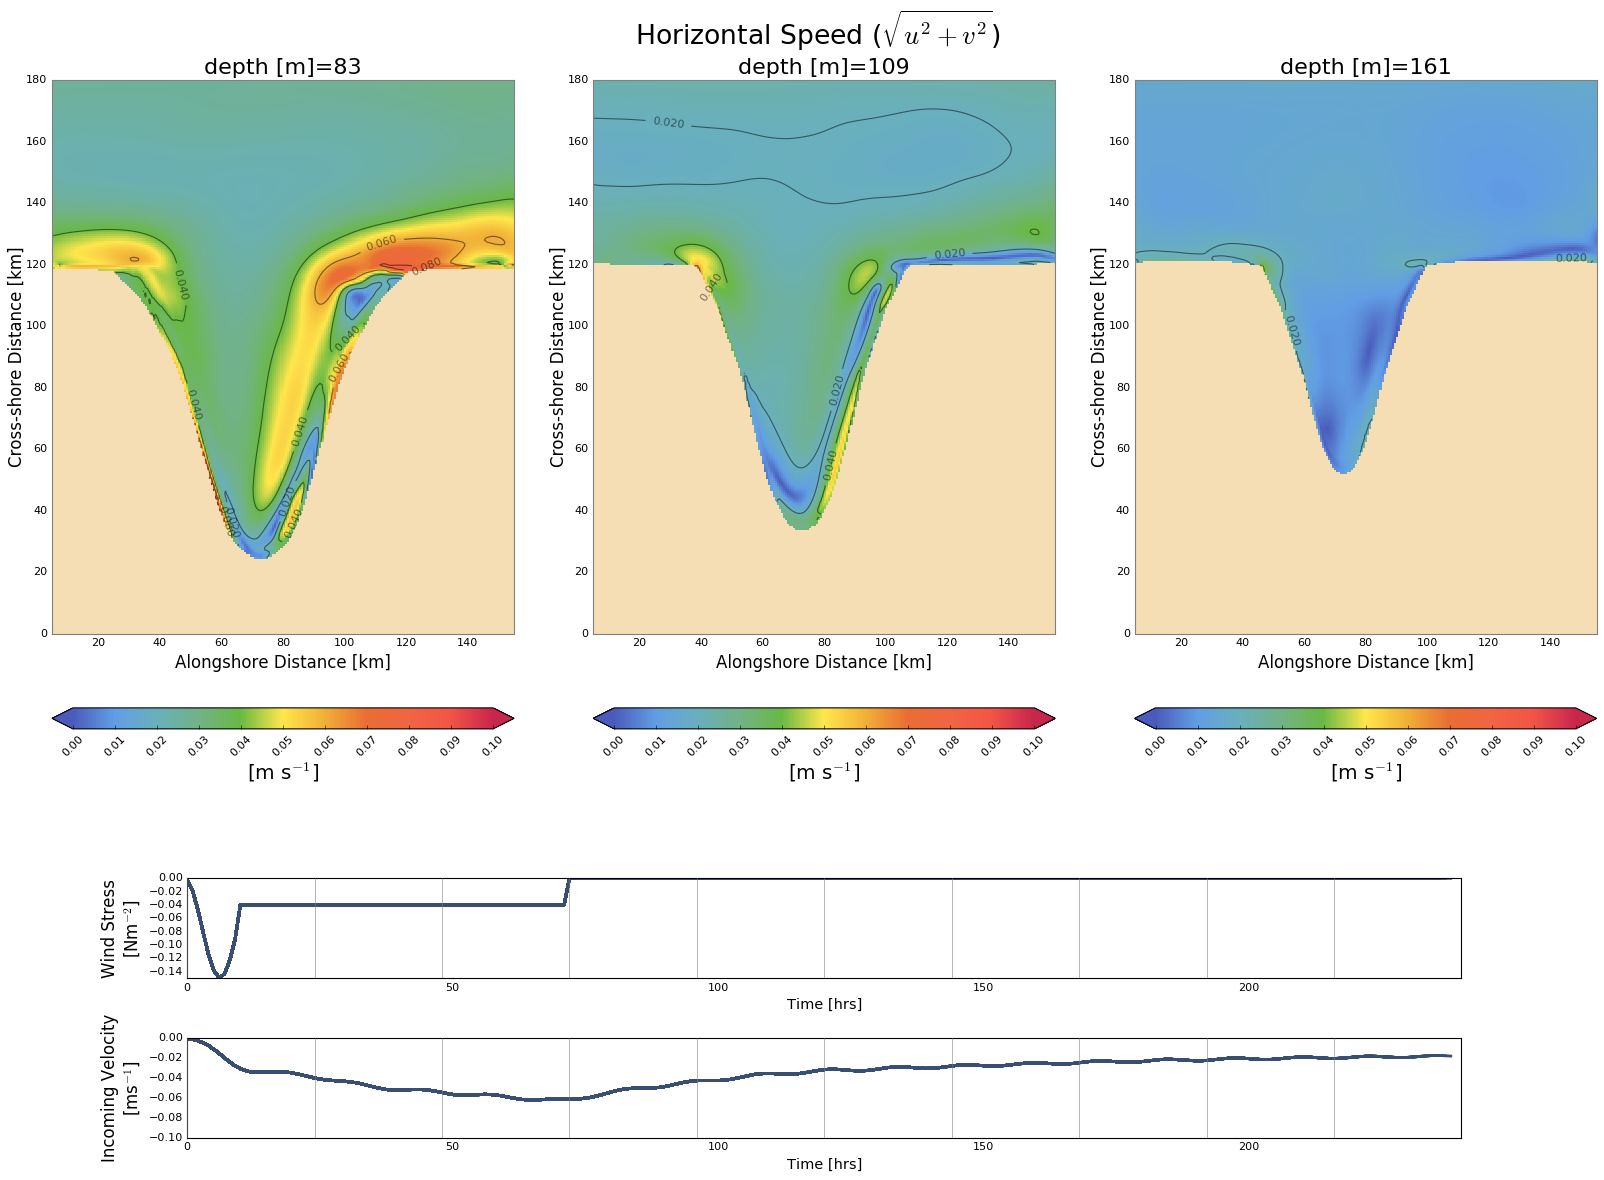

In [16]:
fig = plt.figure(figsize=(20, 15))
ax1 = plt.subplot2grid((7, 12), (0, 0), colspan=4, rowspan=5)
ax2 = plt.subplot2grid((7, 12), (0, 4), colspan=4, rowspan=5, sharey=ax1)
ax3 = plt.subplot2grid((7, 12), (0, 8), colspan=4, rowspan=5, sharey=ax1)
axa = plt.subplot2grid((7, 12), (5, 1), colspan=10, rowspan=1)
axb = plt.subplot2grid((7, 12), (6, 1), colspan=10, rowspan=1)

axes = [ax1, ax2, ax3]
fig, axes, axa, axb = general_functions.set_plots(fig, axes, axa, axb, 'Horizontal Speed ($\sqrt{u^2+v^2}$)')
levels = np.arange(0, 0.12, 0.02)

print(levels)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=10*24)
anim.save('speed_panels.mp4', writer=writer)